# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
import Pkg
Pkg.activate("../")
Pkg.instantiate()


  Activating project at `c:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM`
Precompiling project...
        Info Given CellBasedModels was explicitly requested, output will be shown live 
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not

In [2]:
import Pkg; Pkg.add(["Revise", "GLMakie"])

   Resolving package versions...
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Project.toml`
  No Changes to `C:\Users\u256063\Desktop\Projects\ABM_2\ABM_CBM\Manifest.toml`


In [3]:
using Revise
using CellBasedModels
using CUDA
using Distributions
using GLMakie
# using GeometryBasics
import GLMakie: Point3f, Cylinder, Sphere, NoShading #Can be changes to Cairo or CLMakie

[ Info: Precompiling CellBasedModels [388cb286-f2b1-4654-a3bb-2e137a39c658]
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:187
┌ Warning: CUDA runtime library nvrtc64_112_0.dll was loaded from a system path. This may cause errors.
│ Ensure that you have not set the LD_LIBRARY_PATH environment variable, or that it does not contain paths to CUDA libraries.
└ @ CUDA C:\Users\u256063\.julia\packages\CUDA\jdJ7Z\src\initialization.jl:1

## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [4]:
rod2D = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :type=>Int,
        ),    #Local Interaction Parameters

    model = Dict(
            :n=>Int,
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m 
        dt(vy) =  -β*vy+fy/m 
        dt(theta) =  ω 
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a community with two bacteries and check forces

In [5]:
com = Community(rod2D,
            N=30,
            dt=0.1,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1/100
g = 1/10000
d = 1
#Model constants
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.n=20
#Agent parameters
# com.m = 1
# com.d = 1
# com.l = 3;
#     # You can play to put different positions and angles here and see the behaviour of the interacting bacteries
# com.x = [0.,1]
# com.y = [0.,1]
# com.theta = [0,π/2];

20

In [6]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    if i <= com.n[1]  # agentes del 0 al 4 (long rods)
        com.type[i] = 0
        com.l[i] = 3.0
        com.m[i] = 1.0
        com.d[i] = 1.0
    else       # agentes del 5 al 9 (puntos o discos)
        com.type[i] = 1
        com.l[i] = 0
        com.m[i] = 0.2
        com.d[i] = 0.8
    end
end

In [7]:
evolve!(com,steps=50,saveEach=1,preallocateAgents=0)

In [53]:
function plotMixedAgents2D!(ax, x, y, d, l, angle, type, p; kargs...)
    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)


        if ti== 0  # rods
            colorval = pi
            colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
        else  # puntos
            colorval = RGBf(0, 1, 1)  # rojo puro
            meshscatter!(ax,
                [Point3f(xi, yi, 0.0)];  # ¡usar coordenadas 3D!
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],  # ¡tamaño real 3D!
                color = [colorval],
                kargs...
            )
        end

    end
    return
end


plotMixedAgents2D! (generic function with 1 method)

In [54]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0,maximum(com.pressure))
)
    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

GLMakie.Screen(...)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [21]:
CBMDistributions.rand_pm()

1

In [ ]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64,
                :pTarget => Float64,
                :p => Float64
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64,
                :σ=>Float64
            ),

 
    agentODE = quote
        if type == 0
            dt(l) = growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
            dt(p) = σ*pressure^2/(pressure^2+α^2)
        end
        
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/10 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ww,
                    p=0,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=0)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = -ww,
                    p=0,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=0)
            #Remove the old cell
            @removeAgent()
        end
        if p > pTarget 
            ww = 0 #To add some random torque at division time
            p=0
            #Add a new cell
            aux=CBMDistributions.rand_pm()
            @addAgent(
                    # x=((l+d)*(rand()-1/2)+aux*d/2)*cos(theta)+x,
                    # y=((l+d)*(rand()-1/2)-aux*d/2)*sin(theta)+y,
                    x=(CBMDistributions.uniform(-1,1)*(l+d)/2+aux*d/2)*cos(theta)+x,
                    y=(CBMDistributions.uniform(-1,1)*(l+d)/2-aux*d/2)*sin(theta)+y,
                    l=0,
                    d=0.5,
                    ω = ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=1)

        end

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [ ]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.1,
            simBox = [-100 100;-100 100.],
            );

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.growth = 1E-6 * (sqrt(g*d)) *100000
com.lMax = 3.     
com.σlTarget = .2 
com.α = 50
com.σ = 2
com.type=0

com.m = 1.        
com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  
com.p=0.
com.pTarget = 5.E-3

com.x = 0
com.y = 0
com.theta = 0;

In [27]:
evolve!(com,
        steps=150000,saveEach=1000,
        preallocateAgents=1000,
        saveCurrentState=true,
        progressMessage=(com)->if round(Int,com.t/com.dt)%10000 == 0; println("Step: ",round(Int,com.t/com.dt), " N: ", com.N); end)

Step: 10000 N: 2
Step: 20000 N: 3
Step: 30000 N: 4
Step: 40000 N: 6
Step: 50000 N: 8
Step: 60000 N: 9
Step: 70000 N: 16
Step: 80000 N: 19
Step: 90000 N: 32
Step: 100000 N: 37
Step: 110000 N: 64
Step: 120000 N: 67
Step: 130000 N: 116
Step: 140000 N: 1001
Step: 150000 N: 1000


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\u256063\.julia\packages\Makie\dYDv2\src\scenes.jl:238


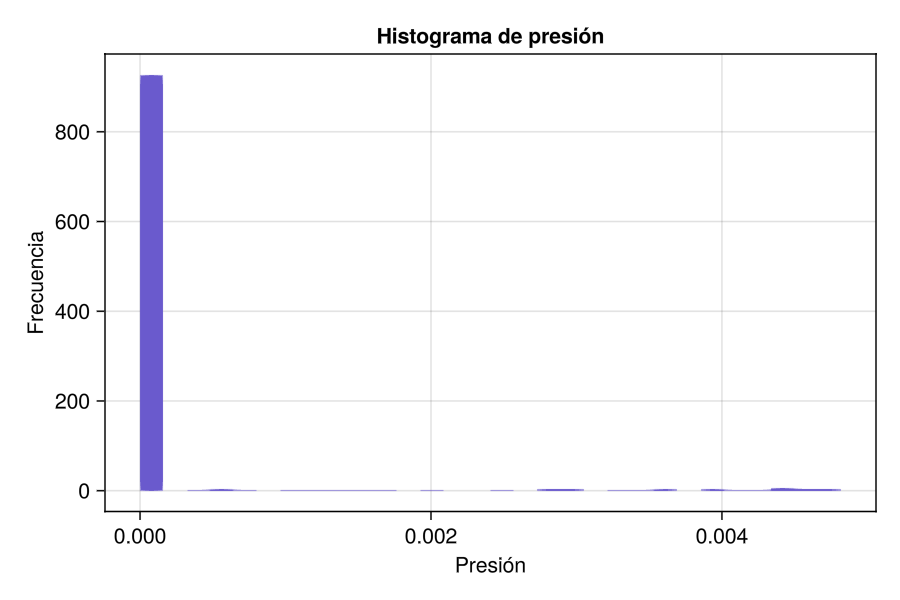

In [31]:
# Elegimos un frame, por ejemplo el último
p = com[end][:p]

# Creamos la figura y el eje
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [35]:
maximum(com.p)

0.004818142391741276

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\u256063\.julia\packages\Makie\dYDv2\src\scenes.jl:238


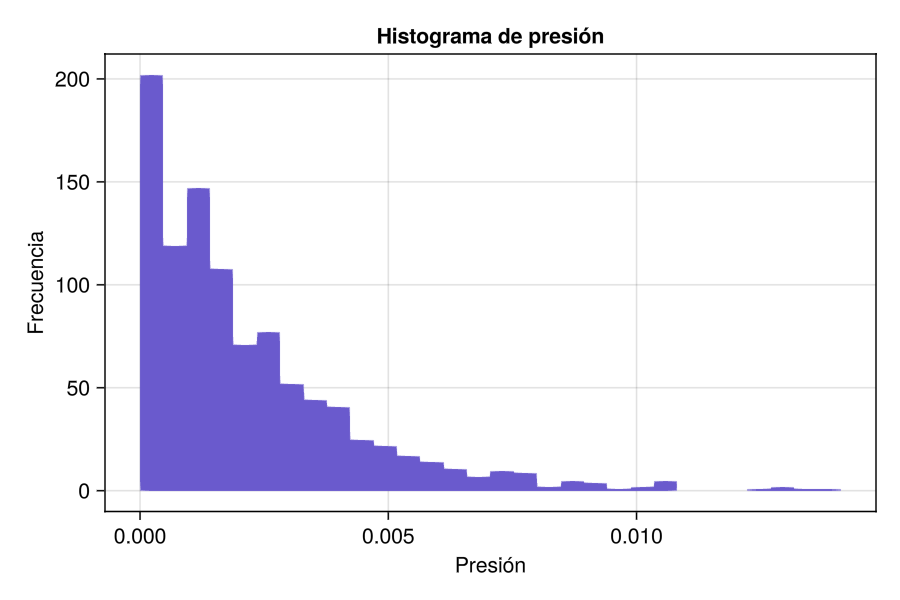

In [33]:
# Elegimos un frame, por ejemplo el último
p = com[end][:pressure]

# Creamos la figura y el eje
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

In [37]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
    )

    xlims!(-20,20)
    ylims!(-20,20)
end

display(fig)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\u256063\.julia\packages\Makie\dYDv2\src\scenes.jl:238


GLMakie.Screen(...)

In [38]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:p],
    colorrange = (0, maximum(com.p))
    )

    xlims!(-20,20)
    ylims!(-20,20)
end

display(fig)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\u256063\.julia\packages\Makie\dYDv2\src\scenes.jl:238


GLMakie.Screen(...)

In [55]:
using GLMakie

fig = Figure(size = (600, 600))
ax = Axis(fig[1, 1]; aspect = DataAspect())

# Cálculo del máximo de presión en todos los frames
max_pressure = maximum(com.pressure)

GLMakie.record(fig, "bacterias_video_pressure.mp4", 1:length(com); framerate = 15) do j
    # Limpiar el eje
    Makie.empty!(ax)

    # Dibujar los agentes (usando tu función personalizada)
    plotMixedAgents2D!(
        ax,
        com[j][:x],
        com[j][:y],
        com[j][:d],
        com[j][:l],
        com[j][:theta],
        com[j][:type],
        com[j][:pressure],
        colorrange = (0, max_pressure)
    )

    xlims!(ax, -20, 20)
    ylims!(ax, -20, 20)
end


"bacterias_video_pressure.mp4"

In [56]:
using GLMakie

fig = Figure(size = (600, 600))
ax = Axis(fig[1, 1]; aspect = DataAspect())

# Cálculo del máximo de presión en todos los frames
max_pressure = maximum(com.p)

GLMakie.record(fig, "bacterias_video_p.mp4", 1:length(com); framerate = 15) do j
    # Limpiar el eje
    Makie.empty!(ax)

    # Dibujar los agentes (usando tu función personalizada)
    plotMixedAgents2D!(
        ax,
        com[j][:x],
        com[j][:y],
        com[j][:d],
        com[j][:l],
        com[j][:theta],
        com[j][:type],
        com[j][:p],
        colorrange = (0, max_pressure)
    )

    xlims!(ax, -20, 20)
    ylims!(ax, -20, 20)
end


"bacterias_video_p.mp4"